# Data Analysis Tutorial for BLM
**Dr Ting Sun** (ting.sun@reading.ac.uk)

*2018 Autumn*

## Basic Workflow

* Import (and pre-process)

* Analyse

* Deliver

## Tools

- essential:
    - `numpy`
    - `pandas`
    - `matplotlib`
- further:
    - `seaborn`
    - `xarray`

## Example 1: Evaporation analysis using Penman equation

### Aim

1. To obtain the essential skills in data analysis
2. To understand the nature of the Penman equation

### Questions

1. How to use the Penman equation to estimate evaporation?
    - what are the parameters that need to be prescribed?
    - what are the input/forcing data you should prepare?
3. Examination of Penman-based results
    - how do we know the accuracy of our estimates? any 'truth' data?
    - what indicators should we calculate?

1. Importing the raw data and preprocessing it to do your own analysis?
    - is it time-aware?
    - any gaps? to fill or not? if needed, how to fill the gaps?

4. What are extrinsic and intrinsic determinants of estimated evaporation based on Penman equation?
    - what parameters are set by us?
    - what forcing data are used?
    - what will happen if we perturb/adjust some of/all the above factors? and why? any physical explanations?

### Import

#### load necessary packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### import raw data

In [2]:
# data_raw=pd.read_csv('WP_PM_rawdata.csv',header=0,skiprows=[1]).dropna(how='all')
data_raw = pd.read_csv('../data/PM_rawdata.csv', header=[0, 1]).dropna(how='all')
data_raw.head().T.head()

,,0,1,2,3,4
TimeStamp,UTC,2.01509e+07,2.01509e+07,2.01509e+07,2.01509e+07,2.01509e+07
Time,hhmm,5,10,15,20,25
Td,deg C,5.89,5.71,5.67,5.58,5.51
Tw,deg C,5.66,5.61,5.51,5.38,5.4
RH,%,98.3,98.9,98.7,98.1,98.7


#### `DateTime`-related pre-processing

In [3]:
# generate correct timestamps
def parse_dt(date, time):
    date = pd.to_datetime(int(date), format='%Y%m%d')
    time_str = str(int(time)).zfill(4)
    timedelta_str = time_str[:2]+'h'+time_str[2:]+'m'
    timedelta = pd.Timedelta(timedelta_str)
#     print(timedelta)
    dt = date+timedelta
    return dt


ser_dt = data_raw.iloc[:, [0, 1]].apply(lambda x: parse_dt(*x), axis=1)

# add the `datetime` column
data_raw['datetime'] = ser_dt
# set a new index series to `data_PM` used for the following analysis
data_PM = data_raw.iloc[:, 2:].set_index('datetime')

### Analyse

#### Modified Penman-Monteith equation:

$$Q_E=L_VE=\frac{s \left(Q^{*} - Q_{G}\right)}{s+ \gamma \left( 1+r_s/r_a \right)}+ \frac{\rho c_{p} \left(e_{T} - e\right)/r_a}{s+ \gamma \left( 1+r_s/r_a \right)}$$

#### Parameters: 
factors that are **NOT changing** during one model run

symbol|meaning|unit|default value
:--|--|-|-
$\gamma$ |psychometric constant |$\mathrm{Pa\ {°C}^{-1}}$|0.67
$\rho$ |density of air | $\mathrm{kg\ {m}^{-3} }$|1.2
$c_p$ |heat capacity of air | $\mathrm{J\ {m}^{-3} \ {°C}^{-1}}$|1004
$r_s$ |surface resistance |$\mathrm{s\ m^{-1}}$|60

#### Forcing data
factors that **should be provided at each time step** during one model run

symbol|meaning|unit
:--|--|-
$Q^{*}$|net wall-wave radiation|$\mathrm{W\ m^{-2}}$
$Q_{G}$|ground heat flux|$\mathrm{W\ m^{-2}}$
$e$|vapour pressure |$\mathrm{Pa}$
$T_a$|air temperature|$\mathrm{°C}$
$U$|wind speed|$\mathrm{m\ s^{-1}}$

#### Intermediate states
factors that are calculated based on **forcing data** and **parameters** but are **NOT the main outputs**


symbol|meaning|unit
:--|--|--
$e_T$|saturation evaporation pressure|$\mathrm{Pa}$
$s$|slope of the saturation vapour pressure vs. temperature curve |$\mathrm{Pa\ °C^{-1}}$
$r_a$|aerodynamic resistance |$\mathrm{s \ m^{-1}}$

#### Implementation: `calc_PM`

* auxiliary functions: we use `atmos` as the basic utility.
    - `esat(Ta)`:  saturation vapour pressure at $T_a$
    - `s(Ta)`: saturation vapour pressure slope at $T_a$
    - `ra(U)`: aerodynamic resistance at $U$

In [4]:
from atmos import calculate as atm_calc

# saturation vapour pressure in [hPa] at Ta


def esat_hPa(Ta_K):
    return atm_calc('es', T=Ta_K)/100

# saturation vapour pressure in [hPa K-1] slope at Ta


def s_esat_hPaKn1(Ta_K):
    dTa_K = 0.001
    d_esat = (esat_hPa(Ta_K)-esat_hPa(Ta_K-dTa_K))
    return d_esat/dTa_K

# aerodynamic resistance in [s m-1] at U


def res_air_smn1(U, z_Ta=1.5, z_U=3, z0=0.01, k=0.4):
    ustar = k*U/np.log(z_U/z0)
    res_air = np.log(z_Ta/z0)/(ustar*k)
    return res_air

* `calc_PM`

In [5]:
def calc_PM(Qn, QG, e, Ta, U, rho=1.2, cp=1004, gamma=0.67, rs=60, z_Ta=1.5, z_U=3, z0=0.01, k=0.4):
    Ta_K = Ta+273.15
#   slope
    s = s_esat_hPaKn1(Ta_K)
#   aerodynamic resistance
    ra = res_air_smn1(U, z_Ta, z_U, z0, k)
#   numerator of PM equation
    num_PM = s*(Qn-QG)+rho*cp*(esat_hPa(Ta_K)-e)/ra
#   denominator of PM equation
    denom_PM = s+gamma*(1+rs/ra)
#     QE from PM equation
    qe = num_PM/denom_PM
    return qe

In [6]:
Qn = data_PM.loc[:, 'Rn'].iloc[:, 0].rename('Qn')
QG = data_PM.loc[:, 'G'].iloc[:, 0].rename('QG')
e = data_PM.loc[:, 'VP_der'].iloc[:, 0]
Ta = data_PM.loc[:, 'Td'].iloc[:, 0]
U = data_PM.loc[:, 'U10'].iloc[:, 0]
QE = calc_PM(Qn, QG, e, Ta, U).rename('QE')
QH = (Qn-QG-QE).rename('QH')

#### Examine the SEB components

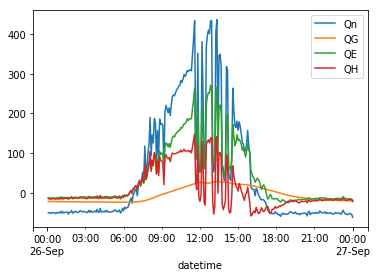

In [7]:
df_SEB=pd.DataFrame([Qn,QG,QE,QH]).T
df_SEB.plot()

#### Exploration

##### Impacts of measurement height of wind speed `z_U`

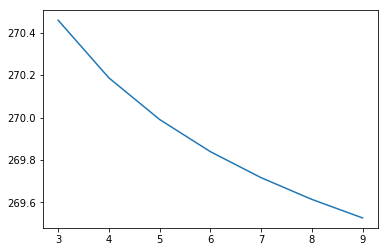

In [8]:
ser_z_U=pd.Series(np.arange(3,10,1))

df_QE_zU=pd.DataFrame({x:calc_PM(Qn, QG, e, Ta, U, z_U=x) for _,x in ser_z_U.iteritems()})

df_QE_zU.max().plot()

##### Impacts of measurement height of surface roughness length `z0`

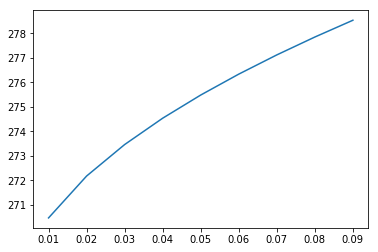

In [9]:
ser_z0=pd.Series(np.arange(0.01,0.1,0.01))

df_QE_z0=pd.DataFrame({x:calc_PM(Qn, QG, e, Ta, U, z0=x) for _,x in ser_z0.iteritems()})

# df_QE_z0.mean().plot.barh()

df_QE_z0.max().plot()

## Example 2: Wind and Temperature Profile

### Basics about wind and temperature profiles

#### neutral conditions

The variation of mean wind speed $\bar{u}$ with height $z$ (in surface layer, above the RSL) above an aerodynamically rough surface can be represented by a logarithmic relation:The variation of mean wind speed $\bar{u}$ with height $z$ (in surface layer, above the RSL) above an aerodynamically rough surface can be represented by a logarithmic relation:

$$\bar{u}=\frac{u_*}{k} \ln \left[ \frac{z-d}{z_0} \right]$$

where where $u_*$ is the friction velocity ($u_*^2=-\overline{u'w'}$) (rate of vertical transfer by turbulence of horizontal momentum per unit mass of air), $z_0$ is the roughness length of the surface for momentum, $d$ is the zero-plane displacement and $k$ is von Karman's constant (0.4).

The logarithmic law is strictly valid only in neutral conditions, i.e. when the effect of buoyancy on turbulence is small compared to the effect of wind shear. In such conditions, the temperature profile in the surface layer will be close to adiabatic (i.e. $dT/dz = –9.8 \textrm{ K km}^{-1}$ or potential temperature is constant with height). When the sensible heat flux is significantly different from zero, Monin-Obukhov theory must be used. 

#### non-neutral conditions

Modifications to the logarithmic profile are required in conditions of non-neutral stability, using the results of Monin-Obukhov theory. This theory of the surface layer derives relations between the vertical variation of wind speed $u(z)$ and potential temperature $\theta(z)$ (which approximates the measured temperature $T$ close to the surface), the scaling factors for momentum and temperature, $u_*$ and $T_*$, and the Monin Obukhov stability parameter,
$$\zeta=\frac{z'}{L}=\frac{k (z-d)}{u_*^3}\frac{g}{\theta_0}\frac{Q_H}{\rho c_p}$$

where $L$ is the Obukhov length and $z' = z - d$.

NB: the surface temperature $\theta_0$ is an absolute temperature (units: K). 

The logarithmic profile relation can be rewritten for wind speed to include the stability corrections:
$$\bar{u}(z)=\frac{u_*}{k} \left[ \ln \left( \frac{z-d}{z_0} \right) -\Psi_m \left( \frac{z-d}{L} \right) + \Psi_m \left( \frac{z_0}{L} \right) \right]$$

and similarly for potential temperature:
$$\bar{\theta}(z)=\theta_0+\frac{T_*}{k} \left[ \ln \left( \frac{z-d}{z_h} \right) -\Psi_h \left( \frac{z-d}{L} \right) + \Psi_h \left( \frac{z_{0h}}{L} \right) \right]$$

where the **turbulent temperature scale** is given by
$$T_*=-\overline{w'T'}/u_*=-Q_H/\left(\rho c_p u_*\right)$$

$\Psi_m$ is the stability correction function for momentum and $\Psi_h$ is the stability correction function for heat. Note that both $T_*$ and $z’/L$ have the opposite sign to $Q_H$ (which is positive in unstable conditions and negative in stable conditions).

#### stability correction functions

The above mentioned *stability corretion functions* are formulated based on [the Monin-Obukhov similarity theory (MOST)](http://glossary.ametsoc.org/wiki/Monin-obukhov_similarity_theory) and their actual forms must be determined theoretically (e.g., [Katul et al. (2011)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.107.268502), [Li et al. (2012)](http://dx.doi.org/10.1063/1.4757660)) or empirically (e.g., [Högström (1988)](https://link.springer.com/10.1007/BF00119875)).

One example by [Kondo (1975)](https://link.springer.com/article/10.1007/BF00232256) is as follows:

* unstable conditions:

$$\Psi_{h} = -2 \ln \left[ \frac{1+(1-16\zeta)^{1/2}}{2}  \right]$$
$$\Psi_{m} = 0.6\Psi_{h}$$

* stable conditions:

$$\Psi_{m} = \Psi_{h}=6 \ln (1+\zeta)$$

### Unstable case

#### import raw data

In [10]:
# data_raw=pd.read_csv('WP_PM_rawdata.csv',header=0,skiprows=[1]).dropna(how='all')
data_raw = pd.read_csv('../data/WP_unstable_rawdata.csv', header=[0, 1]).dropna(how='all')
data_raw

,z,U_obs,T_obs
,(m),(m/s),(C)
0,0.56,1.84,24.91
1,0.80,1.97,NaN
2,1.12,2.16,24.39
3,1.60,2.38,NaN
4,2.24,2.63,23.76
5,3.20,2.89,NaN
6,4.48,3.09,23.90
7,6.40,3.47,NaN


#### implement the stability correction function

In [11]:
# Psi for momentum under unstable condition
def Psi_m_unstable(z_d, L):
    z_L = z_d/L
    Psi_m = 0.6*(2)*np.log((1+(1-16*z_L)**0.5)/2)
    return Psi_m


# wind profile function 
def func_u_z(z, u_star, z0, d=0.01, L=-2.1998, k=0.4):
    crt = np.log((z-d)/z0)-Psi_m_unstable(z-d, L)+Psi_m_unstable(z0, L)
    fit_u_z = u_star/k * crt
    return fit_u_z


# form for fitting
def func_fit_u_z(z, u_star, z0):
    return func_u_z(z, u_star, z0)

#### fit curve by `scipy.optimize`

In [12]:
from scipy import optimize
params, params_covariance = optimize.curve_fit(func_fit_u_z,
                                               data_raw.z.values.flatten(),
                                               data_raw.U_obs.values.flatten())
pd.Series(params,index=['u_star','z0']).to_frame().T

/Users/sunt05/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.
/Users/sunt05/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


,u_star,z0
0,0.468304,0.083681


#### examine the fitted curve

In [13]:
# clean the labels
data_fit = data_raw.copy()[['z', 'U_obs']]
data_fit.columns = data_fit.columns.droplevel(1)

# data_fit
data_fit['U_fit'] = func_fit_u_z(data_fit.z, *params)
data_fit

,z,U_obs,U_fit
0,0.56,1.84,1.705202
1,0.80,1.97,1.980512
2,1.12,2.16,2.225307
3,1.60,2.38,2.470980
4,2.24,2.63,2.691432
5,3.20,2.89,2.914837
6,4.48,3.09,3.117291
7,6.40,3.47,3.324439


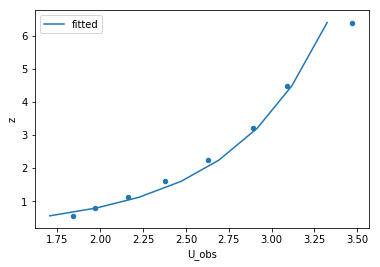

In [14]:
ax = data_fit.plot.line(x='U_fit', y='z', label='fitted')
data_fit.plot.scatter(ax=ax, x='U_obs', y='z')

#### exercise: fit the temperature profile

### Stable case

#### exercise: 

* wind speed profile

* temperature profile

### Exploration:  impacts of surface roughness on the profiles

## Assignment 1 Tasks

1. Identify a study period. 
    * Plot the surface energy and radiation balances for a cloudy and a sunny day. 
        - Check that the fluxes make sense
    * Calculate the mean surface energy and radiation balance fluxes through the day (i.e. an ensemble mean) and plot these. 
    * Plot the ensemble median and the mean of the of $z'/L$.  
    * Describe how the energy partitioning varies through the day and with synoptic conditions 

2. The Penman Monteith equation provides one method to calculate the components of the surface energy balance. It assumes energy balance closure at each model time step. Evaluate the performance of the PM calculations ($Q_H$ and $Q_E$, $\beta$) using the EC data.
    
    * Identify what parameters values were used initially

3. Calculate the canopy resistance from the EC and other data (this can be back-calculated). How do these values compare to the literature/textbooks? 
    * You will need dry conditions (e.g. 12 h since rain – depending on time of day) and solar radiation for the calculations (e.g. $Q^* \gt  \mathrm{20\ W \ m^{-2}}$ )

4. Eddy covariance and other observations allow a number of important parameters to be determined. These may be used as input for models. 
    * Calculate roughness length from the EC data. Calculate the roughness length and zero plane displacement height from the wind profile data. Create a graph to analyse the data (think about wind directions). 
    * Calculate the albedo for the area.  Think about the time of day.  If you had to choose one value to model the site, what would it be

5. Use the roughness length calculated and the canopy resistances to calculate the PM fluxes ($Q_H$ and $Q_E$) for the same period. What is the impact on the evaluation statistics?

6. In principle, assuming all fluxes are accurately measured, the surface energy balance (SEB) should close (i.e. inputs should equal outputs). One way to assess this is to plot the available energy ($Q^*- Q_G$) against the turbulent heat fluxes ($Q_H+Q_E$). If there is closure, each measurement period (e.g. 30 min) should plot on the 1:1 line. 

    * Using the observed SEB data, create a scatter plot, with a 1:1 line and calculate the linear regression through the data to assess the degree of SEB closure. 
    * Does averaging period, stability, wind direction make any difference to energy balance closure? 
    * How do your results compare to the literature? 

7. The sensible heat fluxes can also be determined using the wind profile data. (see spreadsheet discussion at the end of the assignment)

    * Calculate the sensible heat flux using this approach for the same period as your EC analysis 
    * Compare the sensible heat fluxes obtained.
    * Assess the SEB closure again using these results (as above). 

8. Determine the probable errors in your results

9.	(MT49E) For one of the hours for which you have analysed EC data, download the raw 10 Hz data 
    * Calculate the sensible and latent heat fluxes. You will need to perform co-ordinate rotations. 
    * Calculate the Obukhov length for the same period. 
    * Compare your results to the pre-calculated heat fluxes (e.g. add data points to your previous graphs). 
    * Identify what corrections you have made to your calculations compared with other possible corrections you could have used (e.g. see Burba 2013; Kotthaus and Grimmond 2014). Consider the implications of these.

10. Systematically perturb $Q^*$, $Q_G$, canopy resistance rc, roughness length z0 in the Penman Monteith equation. Which uncertainty has the biggest effect on the estimated fluxes? Derive an overall estimate for the accuracy of the Penman-Monteith method for both $Q_E$ and $Q_H$. Do this by assuming reasonable errors in the parameters and variables. What is the impact of assuming neutral conditions versus actual stability conditions on the calculated value of ra? What error in the fluxes does this cause? How will this error vary for extremely unstable or stable conditions?

11. Convert your PM $Q_E$ estimate and your EC $Q_E$ estimate from $\mathrm{W \ m^{-2}}$ to evapotranspiration in $\mathrm{mm\ day^{-1}}$. Compare these rates to the rainfall in the period around your study period. 